<a href="https://colab.research.google.com/github/Khislatz/DS-Unit-2-Kaggle-Challenge/blob/master/module3-cross-validation/Khislat_Zhuraeva_LS_DS_223_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [ ] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Continue to participate in our Kaggle challenge. 
- [ ] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


You won't be able to just copy from the lesson notebook to this assignment.

- Because the lesson was ***regression***, but the assignment is ***classification.***
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd
import numpy as np

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [13]:
train.shape, test.shape

((59400, 41), (14358, 40))

In [0]:
def wrangle(X):
  """Wrange train, validate, and test sets in the same way"""

  #Prevent SettingWithCopyWarning
  X =X.copy()

  #About 3% of the time, latitude has small values near zero (max=-2.000000e-08),
  #outside Tanzania, so we'll treat these values like zero
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  #When columns have zeros and shouldn't, they are like null values. 
  #So we'll replace the zeros with nulls, and impute missing values later. 
  #Also create a "missing indicator" column, because the fact that 
  #values are missing maybe a predictive signal
  cols_with_zeros = ['longitude','latitude', 'construction_year', 
                     'gps_height', 'population']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)
    X[col+'_MISSING'] = X[col].isnull()

   #Drop duplicate columns 
  duplicates =['quantity_group', 'payment_type']
  X = X.drop(columns=duplicates)

   #Drop recorded_by (never varies) and id(always varies, random)
  unusable_variance = ['recorded_by', 'id']
  X=X.drop(columns=unusable_variance)

   #Convert date_recorded to datetime
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True) 

   #Extract components from date_recordedd, then drop the original column
  X['year_recorded'] = X['date_recorded'].dt.year                  
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns='date_recorded')

  #Engineer a feature: how many years from construction_year to date_recorded
  X['years'] = X['year_recorded'] - X['construction_year']
  X['years_MISSING'] = X['years'].isnull()

  #return the wrangled dataframe 
  return X

train = wrangle(train)
test = wrangle(test)

In [0]:
#The status_group column is the target 
target = 'status_group'
features = train.columns.drop(target)
X_train = train[features] 
y_train = train[target]


In [16]:
import category_encoders as ce
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


pipeline = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
)


k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='accuracy')
print(f'Accuracy for {k} folds:', scores)

Accuracy for 3 folds: [0.80671717 0.80641414 0.80429293]


In [17]:
print('Model Hyperparameters:')
print(pipeline.named_steps['randomforestclassifier'])

Model Hyperparameters:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [18]:
scores.mean()

0.8058080808080806

In [19]:
scores.std()

0.0010784927527304321

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


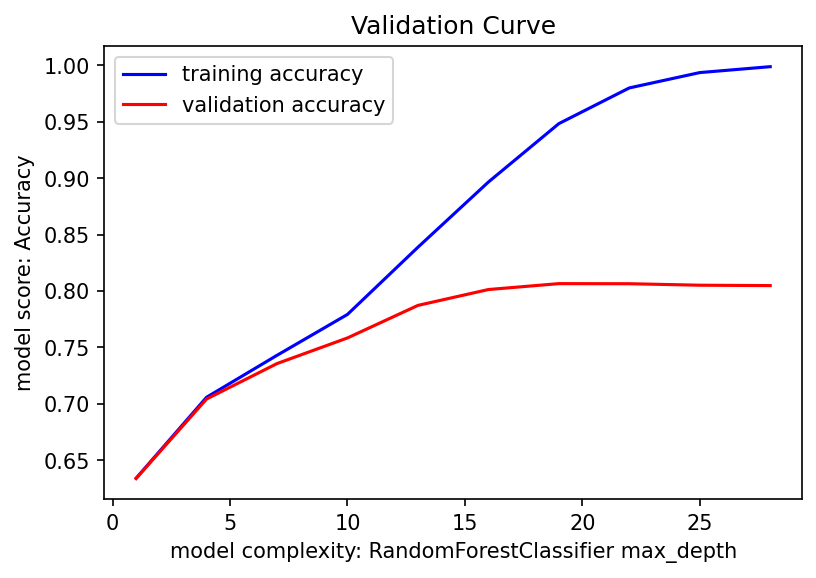

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve


pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=100,n_jobs=-1, random_state=42) 
)

depth = range(1, 30, 3)
train_scores, val_scores = validation_curve(
    pipeline, X_train, y_train,
    param_name='randomforestclassifier__max_depth', 
    param_range=depth, 
    scoring='accuracy', 
    cv=3,
    n_jobs=-1
)

plt.figure(dpi=150)
plt.plot(depth, np.mean(train_scores, axis=1), color='blue', label='training accuracy')
plt.plot(depth, np.mean(val_scores, axis=1), color='red', label='validation accuracy')
plt.title('Validation Curve')
plt.xlabel('model complexity: RandomForestClassifier max_depth')
plt.ylabel('model score: Accuracy')
plt.legend();


In [34]:
val_scores[9].mean()


0.8048484848484848

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__n_estimators': randint(50, 500),
    'randomforestclassifier__bootstrap': [True, False],
    'randomforestclassifier__min_samples_leaf': randint(2, 10),
    'randomforestclassifier__max_depth':[5, 10, 15, 20, None],
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=50, 
    cv=5, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
    
)

search.fit(X_train, y_train);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  8.0min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 27.6min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done 

In [20]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation accuracy', search.best_score_)

NameError: ignored

In [19]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').T

NameError: ignored

In [18]:
pipeline = search.best_estimator_

NameError: ignored

In [21]:
from sklearn.metrics import accuracy_score
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')

X_test = test[features]
y_test = test[target]

test_pred= pipeline.predict(X_test)
acc_score = accuracy_score(y_test, test_pred)


KeyError: ignored

In [0]:
submission = pd.DataFrame({'id':test['id'],'status_group':test_pred})
filename = 'Water Pump Predictions 3.csv'
submission.to_csv(filename,index=False)